### Plot Geodata

If you wanna load new data from open street map you need to install the osmnx package. Otherwise the geopandas package suffices.


### To run the omsnx module in this notebook please do:


#### Use conda to build Python env with osmnx as main so that not upto date version in dependancies used but workable for osmnx

conda config --prepend channels conda-forge

conda create -n ox --strict-channel-priority osmnx

#### go into env
conda activate ox

#### install other libs that are needed for visulization
conda install matplotlib
conda install numpy
conda install -c anaconda ipykernel

#### makes conda env into a kernel which then can be used by jupyter notebook
python -m ipykernel install --user --name=ox

#### other Tool for queries to OpenStreetMap in testing phase
pip install OSMPythonTools


In [1]:
import osmnx as ox # not required for plotting only 
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline




#### How to load geodata from Openstreetmap (takes long)

In [2]:
# Specify the name that is used to seach for the data
#place_name = "Heinsberg, Nordrhein-Westfalen, Germany"
place_name = "Gangelt, Kreis Heinsberg, Nordrhein-Westfalen, Germany"

# Fetch OSM street network from the location, only once! takes forever  
graph = ox.graph_from_place(place_name)
area = ox.gdf_from_place(place_name)
buildings = ox.footprints_from_place(place_name)


#### Load our (reduced) dataset
(if not present in the datafiles folder pls run: python read_geodata.py -ma 1)

In [3]:
min_area = 1 # [1,3] 

area = gpd.read_file('datafiles/Area_Gangelt_MA_'+str(min_area)+'.geojson')
buildings = gpd.read_file('datafiles/Buildings_Gangelt_MA_'+str(min_area)+'.geojson')
streets = gpd.read_file('datafiles/Streets_Gangelt_MA_'+str(min_area)+'.geojson')

#### center of neihbourhood is choosen manually 

In [4]:
list_of_neighbourhood_centers = [Point(5.99,51.03),Point(6.04,50.98),Point(6.05,51.01),Point(5.99,50.99)]

#### plot location

Text(0.5, 1.0, 'Gangelt')

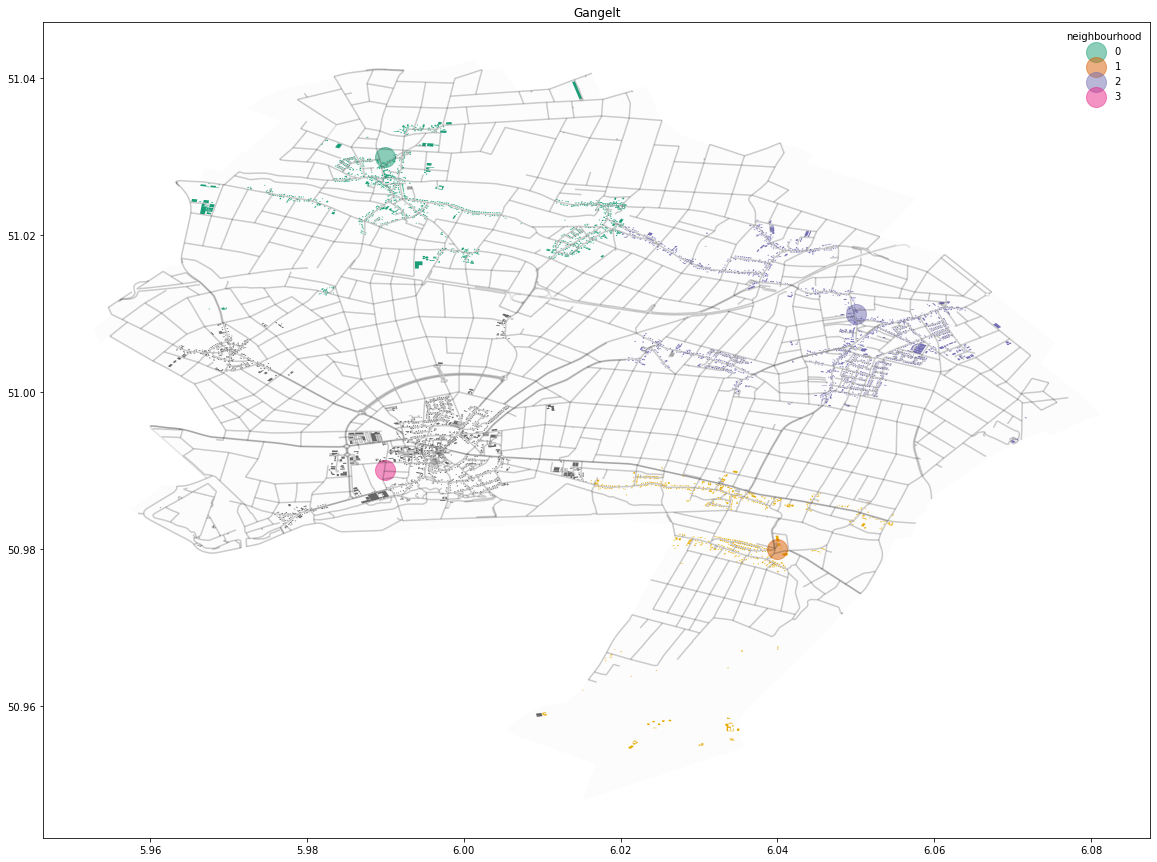

In [6]:
#r1 = gpd.read_file('datafiles/Buildings_Heinsberg.geojson')
import matplotlib.cm as cm 

fig, ax = plt.subplots(figsize=(20,15))
ax = plt.subplot()
cmap = cm.get_cmap('Dark2')

area.plot(ax=ax, color='k' ,alpha=0.01)
streets.plot(ax=ax, color='k', alpha=0.1)
buildings.plot(ax=ax, column='neighbourhood', cmap='Dark2')

for k,p in enumerate(list_of_neighbourhood_centers):
    ax.scatter(p.x,p.y, color = cmap(k), s=400, alpha=0.5, label=k)
ax.legend(title='neighbourhood', frameon=False)    
plt.title('Gangelt')


### zoomed to neighbourhood 

(51.0, 51.06)

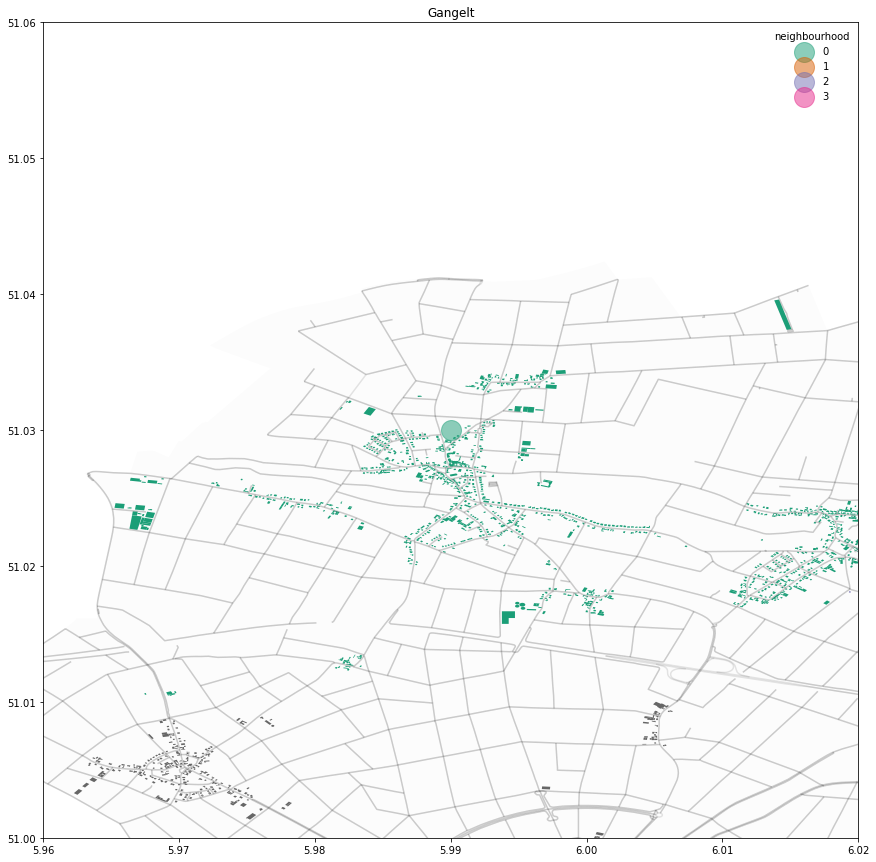

In [9]:
plotrange=0.03
neighbourhood = 0

fig, ax = plt.subplots(figsize=(20,15))
ax = plt.subplot()
cmap = cm.get_cmap('Dark2')

area.plot(ax=ax, color='k' ,alpha=0.01)
streets.plot(ax=ax, color='k', alpha=0.1)
buildings.plot(ax=ax, column='neighbourhood', cmap='Dark2')

for k,p in enumerate(list_of_neighbourhood_centers):
    ax.scatter(p.x,p.y, color = cmap(k), s=400, alpha=0.5, label=k)
ax.legend(title='neighbourhood', frameon=False)    
plt.title('Gangelt')
ax.set_xlim(list_of_neighbourhood_centers[neighbourhood].x-plotrange,list_of_neighbourhood_centers[neighbourhood].x+plotrange)
ax.set_ylim(list_of_neighbourhood_centers[neighbourhood].y-plotrange,list_of_neighbourhood_centers[neighbourhood].y+plotrange)

### list of 'amenities'

In [10]:
print(buildings['amenity'].unique())

[None 'restaurant' 'townhall' 'place_of_worship' 'cafe' 'kindergarten'
 'pub' 'doctors' 'fire_station' 'pharmacy' 'dentist'
 'animal_physiotherapy' 'trailer_parking' 'social_facility']


In [11]:
buildings['neighbourhood'].unique()

array([3, 2, 0, 1])

In [12]:
#### number of locations

In [13]:
len(buildings)

5019

### voronoi prob

not implemented idea to assign neighbourhoods 

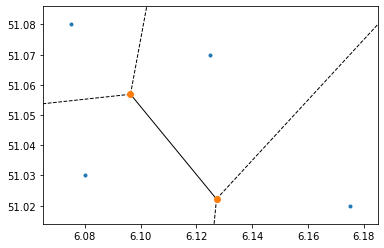

In [14]:
from scipy.spatial import Voronoi, voronoi_plot_2d
points = np.random.random((10, 2))

points =np.array([[6.080,51.03],
                   [6.175,51.02],
                   [6.075,51.08],
                   [6.125,51.07]])
vor = Voronoi(points)
voronoi_plot_2d(vor)
vor.points

v=vor.close()

Link for amenities:
https://wiki.openstreetmap.org/wiki/Key:amenity#Healthcare

In [15]:
buildings_of_interest = ['clinic',
                         'doctors',
                         'nursing_home',
                         'pharmacy',
                         'social_facility',
                         'hospital',
                         'school',
                         'kindergarten',
                         'university',
                         'library',
                         'marketplace']
#get all the interesting amenity in the place of interest. !!BEWARE!! not all buildings have amenity so supermarket is separate query
bois = ox.pois_from_place(place_name, amenities=buildings_of_interest)

In [16]:
#extra just for hospitals for nicer visulisation
#boish = ox.pois_from_place(place_name, amenities=['hospital'])
#boisr = ox.pois_from_place(place_name, shop=)

In [17]:
#idea check to see if ox.pois_from_place(place_name, amenities=buildings_of_interest) and ox.footprints_from_place(place_name) 
#do the same not finished but they are not, for Wedding!
bos = buildings[buildings['amenity'].isin(buildings_of_interest)]
bos

,building,amenity,healthcare,healthcare:speciality,building:levels,school_type,type,members,building_coordinates_x,building_coordinates_y,building_area,neighbourhood,geometry
243,yes,kindergarten,None,None,None,None,None,None,5.996713,50.995960,8.256642e-08,3,"POLYGON ((5.99668 50.99605, 5.99665 50.99604, ..."
579,yes,doctors,doctor,general,None,None,None,None,5.985744,51.027793,2.212507e-08,0,"POLYGON ((5.98564 51.02776, 5.98564 51.02776, ..."
1263,yes,kindergarten,None,None,None,None,None,None,6.041098,51.017477,7.811261e-08,1,"POLYGON ((6.04109 51.01760, 6.04108 51.01759, ..."
1447,yes,pharmacy,None,None,None,None,None,None,6.049861,51.008853,4.366164e-08,1,"POLYGON ((6.04982 51.00892, 6.04981 51.00893, ..."
3104,yes,social_facility,None,None,None,None,None,None,6.037559,51.021142,1.195700e-08,1,"POLYGON ((6.03750 51.02118, 6.03745 51.02115, ..."
3676,yes,doctors,doctor,general,None,None,None,None,6.049051,51.012965,1.903713e-08,1,"POLYGON ((6.04898 51.01302, 6.04895 51.01293, ..."


In [19]:
#start of different idea to access OpenStreetMap and retrive data
#aĺlows to make own queries with more variables than ameniety so longterm better solution
from OSMPythonTools.nominatim import Nominatim
#get area data by area name. very convenient
nominatim = Nominatim()
#get area data here id by area name
areaId = nominatim.query('Berlin, Germany').areaId()
areaId

3600062422

In [20]:
#here the query for the buildings will happen
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
buildings_of_interest = ['clinic',
                         'doctors',
                         'nursing_home',
                         'pharmacy',
                         'social_facility',
                         'hospital',
                         'school',
                         'kindergarten',
                         'university',
                         'library',
                         'marketplace']
#overpass is the nicest api to use, at least there were examples for this tool
overpass = Overpass()
#query to api, saddly right now only one selector possible but idea is to loop or find help
query = overpassQueryBuilder(area=areaId, elementType=['node','way', 'relation'], selector='"amenity"="hospital"', includeGeometry=True)
#saves data as some kind of formated list
result = overpass.query(query)
result

In [22]:
import geopandas as gpd
#in result.elements list of the actual things. to my understanding in GeoJson format hope is that geopanda can use them
result.elements()[1]

<bound method Element.geometry of <OSMPythonTools.element.Element object at 0x12a71a250>>